In [152]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os

from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

In [151]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
data = pd.concat([train, test], axis=0)
#train.drop(['village'], axis =1, inplace = True)
#test.drop(['village'], axis =1, inplace = True)

In [134]:
def Feature_engineer(df):
    #floor
    '''
    df.loc[df['txn_floor'].isna(), 'department'] = 1 
    df.loc[df['txn_floor'].notna(), 'department'] = 0
    df.loc[df['txn_floor'].isna(), 'txn_floor'] = df.loc[df['txn_floor'].isna(), 'total_floor'] 
    df['avg_height_floor'] = df['txn_floor'] / df['total_floor'] 
    df['avg_height_floor'].fillna(0, inplace = True)
    '''
    df['avg_height_floor'] = df['txn_floor'] / df['total_floor'] 
    #location
    df['town'] = df['town'].astype('category')
    
    #date
    df['day_between_txn_complete'] = df['txn_dt'] - df['building_complete_dt']
    df['year_between_txn_complete'] = round(df['day_between_txn_complete'] / 365)
    
    #area
    #df['land*bulid_area'] = df['land_area'] * df ['building_area']
    df['land/bulid_area'] = df['land_area'] / df ['building_area']
    df['house_area'] = df['building_area'] - df['parking_area']
    df['house_rate']  = df['building_area'] / df['house_area']
    
    #parking
    df['miss_parking_area'] = 0
    df['miss_parking_price'] = 0
    df.loc[df['parking_area'].isna(), 'miss_parking_area'] = 1
    df.loc[df['parking_price'].isna(), 'miss_parking_price'] = 1
    df['parking_way'] = df['parking_way'].astype('category')

    #building   #building_type = 4 is house
    df['building_use'] = df['building_use'].astype('category')
    df['building_material'] = df['building_material'].astype('category')
    
    #10 50 100 250 500 1000 5000 10000
    df['diff_500_50'] = df['N_500'] - df['N_50']
    df['diff_1000_500'] = df['N_1000'] - df['N_500']
    df['diff_5000_1000'] = df['N_5000'] - df['N_1000']
    df['diff_10000_5000'] = df['N_10000'] - df['N_5000']
    df['rate_500_50'] = df['N_500'] / df['N_50']
    df['rate_1000_500'] = df['N_1000'] / df['N_500']
    df['rate_5000_1000'] = df['N_5000'] / df['N_1000']
    df['rate_10000_5000'] = df['N_10000'] / df['N_5000']
    
    #MIN
    rank_df = df[[i for i in df.columns if 'MIN' in i]].rank(axis =1)
    rank_df = rank_df.add_prefix('Rank_')
    df = pd.concat([df, rank_df], axis=1)
    
    category_cols  = ['city', 'building_material', 'building_use', 'parking_way']
    '''
    numerical_cols = ['building_area', 'land_area', 'day_between_txn_complete', 'txn_dt', 'building_complete_dt']
    statistics = ['mean', 'median', 'max', 'min']
    for category in category_cols:
        for numerical in numerical_cols:
            for stat in statistics:
                df[numerical + '_' + stat + '_gb_' + category] = df.groupby([category])[numerical].transform(stat)
                df[numerical + '_diff_' + stat + '_gb_' + category] = df[numerical] - df[numerical + '_' + stat + '_gb_' + category]
                df.drop([numerical + '_' + stat + '_gb_' + category], inplace = True, axis = 1)
    
    #interection
    
    inter_cols = ['parking_way', 'building_use', 'building_material']
    for i in range(3):
        for j in range(3):
            if j > i:
                df['inter_btw_' + inter_cols[i] + '_' + inter_cols[j]] = df.apply(lambda x : str(x[inter_cols[i]]) + str(x[inter_cols[j]]), axis=1)
                df['inter_btw_' + inter_cols[i] + '_' + inter_cols[j]] = df['inter_btw_' + inter_cols[i] + '_' + inter_cols[j]].astype('category')
    '''
    
    df.drop(['village'], axis = 1, inplace = True)
    df.drop([i for i in df.columns if 'index' in i and np.sum(df[i]) == 70000], axis = 1, inplace = True)
    return df

In [135]:
def c_hit(preds, train_data):
    trues  = train_data.get_label()
    trues = np.expm1(trues)
    preds = np.expm1(preds)
    scores = ((np.absolute(preds - trues) / trues) <= 0.1)
    hit_error = np.sum(scores) / train_data.num_data()
    return 'Hit_Score', round(hit_error * 10000), True

def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [136]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [5]:
def cat_model(split_num, train, test,features, stratified = False, if_one_hot = True):
    category_cols = ['building_material','building_use','parking_way', 'city']
    
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000, 'max_depth' : -1, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.8,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9
    }

    features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log', 'building_type']] 
     
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        train_x = train.iloc[trn_idx][features]
        train_y = train['total_price_log'].iloc[trn_idx]
        val_x = train.iloc[val_idx][features]
        val_y = train['total_price_log'].iloc[val_idx]
        
        clf = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = 42,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                 cat_features = category_cols
                                )
        clf.fit(train_x, train_y,
                 eval_set=(val_x, val_y),
                 use_best_model=True,
                 verbose=1000)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features])
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
        yhat = np.expm1(oof[val_idx])
        Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
        print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
        print('-'*30)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit rate : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions, round(Hit_score, 4) /len(train) * 10000, oof


SyntaxError: invalid syntax (<ipython-input-5-8d4f44f4a097>, line 51)

In [149]:
def lgb_model(split_num, train, test,cat_col, stratified = False):
    

    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits = split_num, random_state=42, shuffle=True)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    

    param ={
        'n_estimators': 1000000, 'max_depth' : -1, 'num_leaves' :20,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.8,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9, 'num_thread' :4
    }

    features = [i for i in train.columns if i not in ['building_id','total_price_log', 'building_type', 'total_price']] 
    print(len(features))       
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=10000, early_stopping_rounds= 10000, categorical_feature=cat_cols, feval=lambda preds, train_data: [c_hit(preds, train_data)],)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        y   = np.expm1(train['total_price_log'].iloc[val_idx]) 
        yhat = np.expm1(oof[val_idx])
        Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
        print('fold {} hit_score : {}'.format(fold_ + 1, round(Hit_score, 4) /len(train.iloc[val_idx]) * 10000))
        print('-'*30)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
#     print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
#     print('-'*30)
    y = np.expm1(train['total_price_log']) 
    yhat = np.expm1(oof)
    Hit_score = np.sum([1 for i in np.abs((y - yhat) / y)  if i <= 0.1 ])
    print('Hit ratye : {}'.format(round(Hit_score, 4) /len(train) * 10000))
    
    display_importances(feature_importance_df)
    return predictions, oof


In [7]:
begin = time.time()
avg_hit_rate = 0
prediction_df = pd.DataFrame()
hit_score_list = []
train_num_list = []
building_df_list   = []
oof_list       = []

for b_type in train['building_type'].unique():
    temp_train = train[train['building_type'] == b_type]
    temp_test  = test[test['building_type'] == b_type]
    temp_train.drop(['building_type'], axis =1, inplace =True)
    temp_test.drop(['building_type'], axis =1, inplace =True)
    target_df = temp_train.groupby(['city', 'town']).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()
    target_df.columns = [i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in target_df.columns.tolist()]
    target_df['price_land_rate_median'] = target_df['total_price_median'] / target_df['land_area_median']
    target_df['price_building_rate_median'] = target_df['total_price_median'] / target_df['building_area_median']
    target_df['price_land_rate_mean'] = target_df['total_price_mean'] / target_df['land_area_mean']
    target_df['price_building_rate_mean'] = target_df['total_price_mean'] / target_df['building_area_mean']

    combine_cols = ['city', 'town', 'price_land_rate_median', 'price_building_rate_median', 'price_land_rate_mean', 'price_building_rate_mean']
    temp_train = pd.merge(temp_train, target_df[combine_cols], on =['city', 'town'], how='left')
    temp_test = pd.merge(temp_test, target_df[combine_cols], on =['city', 'town'], how='left')

    
    preds, hit_score, oof = lgb_model(5, temp_train, temp_test, if_one_hot=False)
    temp = pd.DataFrame({'building_id' : temp_test['building_id'], 'total_price' : preds})
    prediction_df = pd.concat([prediction_df, temp], axis=0)
    
    print('building_type : {}'.format(b_type))
    print('Train_num: {}'.format(len(temp_train)))
    print('Test_num: {}'.format(len(temp_test)))
    print('-'*1000)
    hit_score_list.append(hit_score)
    train_num_list.append(len(temp_train))
    building_df_list.append(b_type)
    oof_list.append(oof)
    avg_hit_rate += hit_score / 60000 * len(temp_train)

Result_df = pd.DataFrame({'City' : building_df_list,
                        'Train_num' : train_num_list,
                        'Hit_score' : hit_score_list})

print('Avg hit_score : {}'.format(avg_hit_rate))
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))
Submission(prediction_df['building_id'], np.expm1(prediction_df['total_price']))

236
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0277203	valid_1's rmse: 0.174301
[20000]	training's rmse: 0.0142342	valid_1's rmse: 0.174237
Early stopping, best iteration is:
[17029]	training's rmse: 0.0164686	valid_1's rmse: 0.174194
fold 1 hit_score : 5877.609108159393
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0282254	valid_1's rmse: 0.188706
Early stopping, best iteration is:
[6647]	training's rmse: 0.0415305	valid_1's rmse: 0.188576
fold 2 hit_score : 5671.570953962981
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.02848	valid_1's rmse: 0.198903
[20000]	training's rmse: 0.014843	valid_1's rmse: 0.198932
Early stopping, best iteration is:
[12003]	training's rmse: 0.023839	valid_1's rmse: 0.19883
fold 3 hit_score : 5690.555291884195
------------------------------
Training until val

Hit rate : 6297.877764323497
building_type : 0
Train_num: 15691
Test_num: 2583
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [138]:
data = Feature_engineer(data)
gc.collect()

43280

In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 9999
Columns: 242 entries, III_10 to Rank_X_MIN
dtypes: category(4), float64(60), int64(177), object(1)
memory usage: 128.0+ MB


In [94]:
[i for i in data.columns if data[i].dtypes not in ['int64', 'float64', 'O']]

['building_material', 'building_use', 'parking_way', 'town']

324
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0215973	valid_1's rmse: 0.174992
[20000]	training's rmse: 0.0109037	valid_1's rmse: 0.174936
[30000]	training's rmse: 0.00776935	valid_1's rmse: 0.174929
Early stopping, best iteration is:
[24053]	training's rmse: 0.00930233	valid_1's rmse: 0.174923
fold 1 hit_score : 5815.939278937381
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0220992	valid_1's rmse: 0.187176
[20000]	training's rmse: 0.0111659	valid_1's rmse: 0.187037
Early stopping, best iteration is:
[14205]	training's rmse: 0.015349	valid_1's rmse: 0.187016
fold 2 hit_score : 5652.586616041766
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.022377	valid_1's rmse: 0.199788
[20000]	training's rmse: 0.0113726	valid_1's rmse: 0.199601
[30000]	training's rmse: 0.00811805	valid_1's rmse: 0.1

[20000]	training's rmse: 0.0153129	valid_1's rmse: 0.165593
[30000]	training's rmse: 0.0103096	valid_1's rmse: 0.165529
[40000]	training's rmse: 0.00805417	valid_1's rmse: 0.165513
Early stopping, best iteration is:
[38647]	training's rmse: 0.00829035	valid_1's rmse: 0.16551
fold 1 hit_score : 6374.641605606881
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0311989	valid_1's rmse: 0.161489
[20000]	training's rmse: 0.0149483	valid_1's rmse: 0.160963
[30000]	training's rmse: 0.0101126	valid_1's rmse: 0.160896
[40000]	training's rmse: 0.00792446	valid_1's rmse: 0.160886
[50000]	training's rmse: 0.00663048	valid_1's rmse: 0.160887
Early stopping, best iteration is:
[41206]	training's rmse: 0.00773768	valid_1's rmse: 0.160879
fold 2 hit_score : 6303.377947737412
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0317061	valid_1's rmse: 0.179867


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

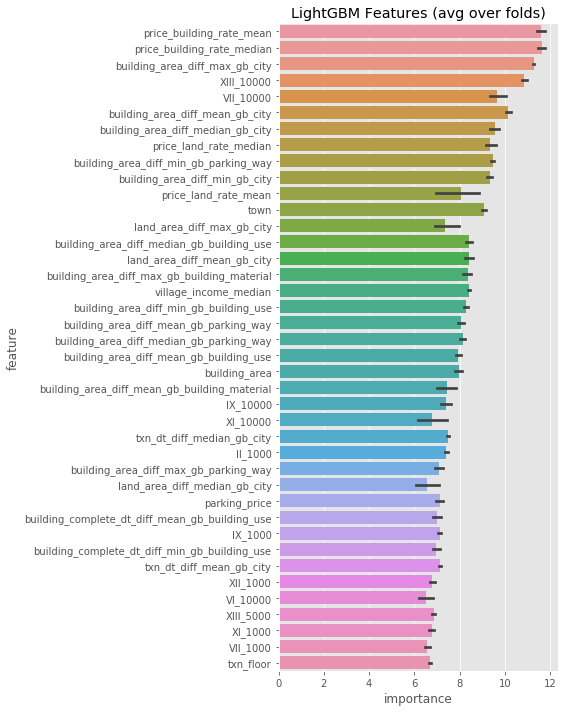

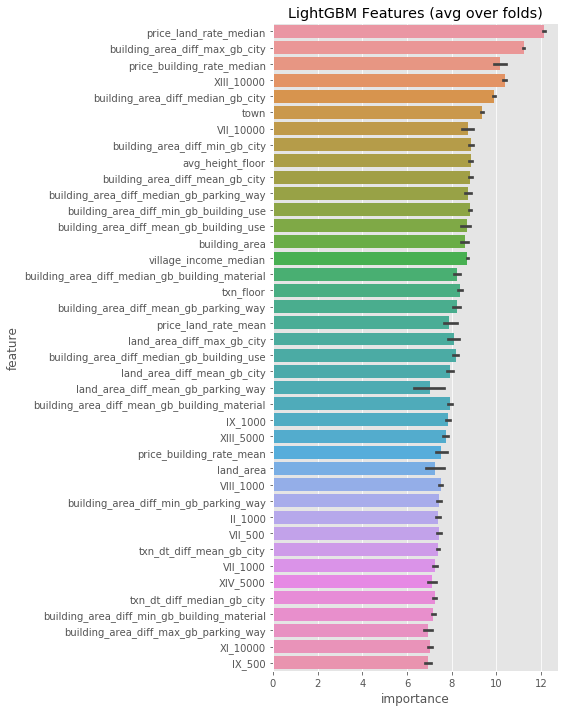

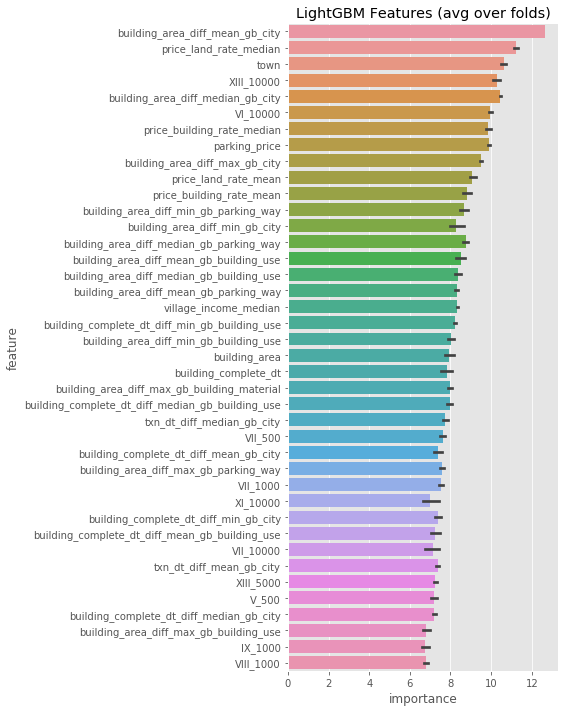

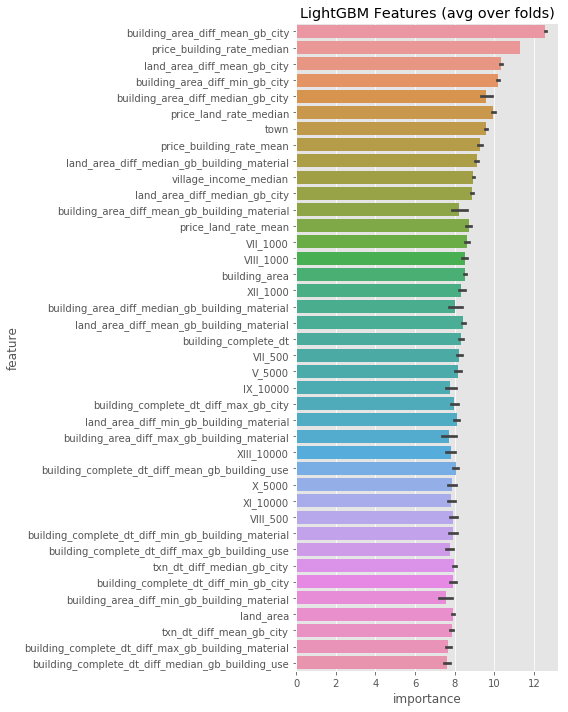

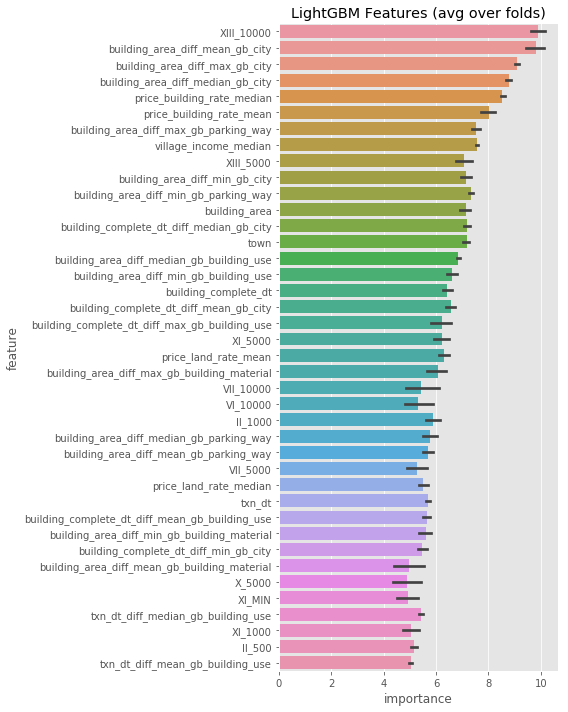

In [97]:
begin = time.time()
avg_hit_rate = 0
prediction_df = pd.DataFrame()
hit_score_list = []
train_num_list = []
building_df_list   = []
oof_list       = []
cat_cols = [i for i in data.columns if data[i].dtypes not in ['int64', 'float64', 'O']]
train = data[:60000]
test = data[60000:]
for b_type in train['building_type'].unique():
    temp_train = train[train['building_type'] == b_type]
    temp_test  = test[test['building_type'] == b_type]
    temp_train.drop(['building_type'], axis =1, inplace =True)
    temp_test.drop(['building_type'], axis =1, inplace =True)
    target_df = temp_train.groupby(['city', 'town']).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()
    target_df.columns = [i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in target_df.columns.tolist()]
    target_df['price_land_rate_median'] = target_df['total_price_median'] / target_df['land_area_median']
    target_df['price_building_rate_median'] = target_df['total_price_median'] / target_df['building_area_median']
    target_df['price_land_rate_mean'] = target_df['total_price_mean'] / target_df['land_area_mean']
    target_df['price_building_rate_mean'] = target_df['total_price_mean'] / target_df['building_area_mean']

    combine_cols = ['city', 'town', 'price_land_rate_median', 'price_building_rate_median', 'price_land_rate_mean', 'price_building_rate_mean']
    temp_train = pd.merge(temp_train, target_df[combine_cols], on =['city', 'town'], how='left')
    temp_test = pd.merge(temp_test, target_df[combine_cols], on =['city', 'town'], how='left')

    
    preds, hit_score, oof = lgb_model(5, temp_train, temp_test, cat_cols, stratified=False)
    temp = pd.DataFrame({'building_id' : temp_test['building_id'], 'total_price' : preds})
    prediction_df = pd.concat([prediction_df, temp], axis=0)
    
    print('building_type : {}'.format(b_type))
    print('Train_num: {}'.format(len(temp_train)))
    print('Test_num: {}'.format(len(temp_test)))
    print('-'*1000)
    hit_score_list.append(hit_score)
    train_num_list.append(len(temp_train))
    building_df_list.append(b_type)
    oof_list.append(oof)
    avg_hit_rate += hit_score / 60000 * len(temp_train)

Result_df = pd.DataFrame({'City' : building_df_list,
                        'Train_num' : train_num_list,
                        'Hit_score' : hit_score_list})

print('Avg hit_score : {}'.format(avg_hit_rate))
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))
Submission(prediction_df['building_id'], np.expm1(prediction_df['total_price']))

In [ ]:
begin = time.time()
avg_hit_rate = 0
prediction_df = pd.DataFrame()
hit_score_list = []
train_num_list = []
building_df_list   = []
oof_list       = []
cat_cols = [i for i in data.columns if data[i].dtypes not in ['int64', 'float64', 'O']]
cat_cols = ['building_material', 'building_use', 'parking_way']
train = data[:60000]
test = data[60000:]
for b_type in train['building_type'].unique():
    temp_train = train[train['building_type'] == b_type]
    temp_test  = test[test['building_type'] == b_type]
    temp_train.drop(['building_type'], axis =1, inplace =True)
    temp_test.drop(['building_type'], axis =1, inplace =True)
    target_df = temp_train.groupby(['city', 'town','village']).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()
    target_df.columns = [i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in target_df.columns.tolist()]
    target_df['price_land_rate_median'] = target_df['total_price_median'] / target_df['land_area_median']
    target_df['price_building_rate_median'] = target_df['total_price_median'] / target_df['building_area_median']
    target_df['price_land_rate_mean'] = target_df['total_price_mean'] / target_df['land_area_mean']
    target_df['price_building_rate_mean'] = target_df['total_price_mean'] / target_df['building_area_mean']

    combine_cols = ['city', 'town', 'price_land_rate_median', 'price_building_rate_median', 'price_land_rate_mean', 'price_building_rate_mean']
    temp_train = pd.merge(temp_train, target_df[combine_cols], on =['city', 'town'], how='left')
    temp_test = pd.merge(temp_test, target_df[combine_cols], on =['city', 'town'], how='left')

    
    preds, oof = lgb_model(10, temp_train, temp_test, cat_cols)
    temp = pd.DataFrame({'building_id' : temp_test['building_id'], 'total_price' : preds})
    prediction_df = pd.concat([prediction_df, temp], axis=0)
    
    print('building_type : {}'.format(b_type))
    print('Train_num: {}'.format(len(temp_train)))
    print('Test_num: {}'.format(len(temp_test)))
    print('-'*1000)
    hit_score_list.append(hit_score)
    train_num_list.append(len(temp_train))
    building_df_list.append(b_type)
    oof_list.append(oof)
    avg_hit_rate += hit_score / 60000 * len(temp_train)

Result_df = pd.DataFrame({'City' : building_df_list,
                        'Train_num' : train_num_list,
                        'Hit_score' : hit_score_list})

print('Avg hit_score : {}'.format(avg_hit_rate))
print('總共花：{} 分'.format((time.time() - begin) / 60))
print('現在時間 ： {}'.format(datetime.datetime.today().strftime('%m-%d-%H-%M')))
Submission(prediction_df['building_id'], np.expm1(prediction_df['total_price']))

236
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.046468	training's Hit_Score: 9629	valid_1's rmse: 0.0478845	valid_1's Hit_Score: 9592
[20000]	training's rmse: 0.0214295	training's Hit_Score: 9986	valid_1's rmse: 0.0228742	valid_1's Hit_Score: 9980
[30000]	training's rmse: 0.011822	training's Hit_Score: 9998	valid_1's rmse: 0.0134028	valid_1's Hit_Score: 9996
[40000]	training's rmse: 0.00753414	training's Hit_Score: 10000	valid_1's rmse: 0.00935587	valid_1's Hit_Score: 9998
Early stopping, best iteration is:
[38742]	training's rmse: 0.00791595	training's Hit_Score: 10000	valid_1's rmse: 0.00970368	valid_1's Hit_Score: 9998
fold 1 hit_score : 9997.819212735798
------------------------------
Training until validation scores don't improve for 10000 rounds.
[10000]	training's rmse: 0.0465365	training's Hit_Score: 9618	valid_1's rmse: 0.0486769	valid_1's Hit_Score: 9562
[20000]	training's rmse: 0.0215854	training's Hit_Score: 9988	valid_1's rms

['building_material', 'city', 'txn_dt', 'total_floor', 'building_use', 'building_complete_dt', 'parking_way', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'town', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'village', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_index_50', 'I_100', 'I_250', 'I_500', 'I_index_500', 'I_1000', 'I_index_1000', 'I_5000', 'I_index_5000', 'I_10000', 'I_index_10000', 'I_MIN', 'II_10', 'II_50', 'II_index_50', 'II_100', 'II_250', 'II_500', 'II_index_500', 'II_1000', 'II_index_1000', 'II_5000', 'II_index_5000', 'II_10000', 'II_index_10000', 'II_MIN', 'III_10', 'III_50', 'III_index_50', 'III_100', 'III_250', 'III_500', 'III_index_500', 'III_1000', 'III_index_1000', 'III_5000', 'III_index

(array([16.34719484, 16.13828105, 14.92950521, ..., 15.76563516,
        14.90128239, 13.88535262]),
 4275.562822286505,
 array([14.17152205, 16.44780642, 16.2859407 , ..., 14.83019657,
        17.43820383, 13.88926561]))

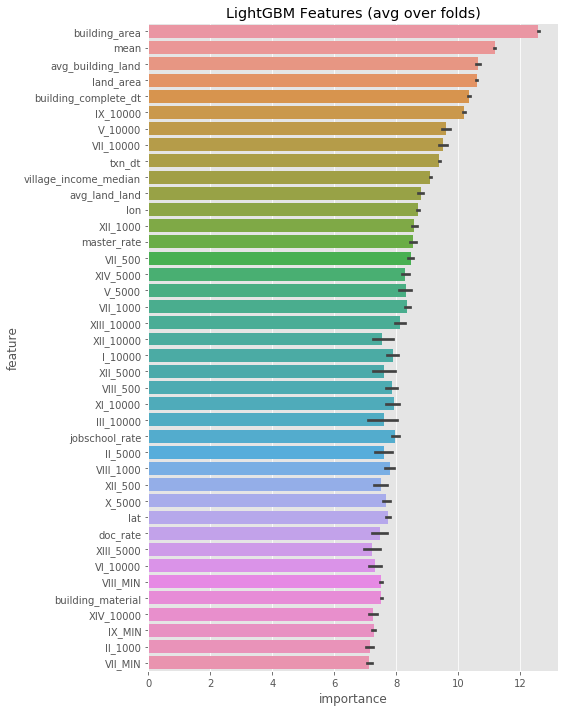

In [55]:
temp_train = train[train['building_type'] == 4]
temp_test = test[test['building_type'] == 4]
temp_train['avg_building_land'] = temp_train['building_area'] / temp_train['total_floor']
temp_test['avg_building_land'] = temp_test['building_area'] / temp_test['total_floor']

temp_train['avg_land_land'] = temp_train['land_area'] / temp_train['total_floor']
temp_test['avg_land_land'] = temp_test['land_area'] / temp_test['total_floor']

mean_area = temp_train.groupby(['city', 'town']).agg({'land_area' : 'mean', 'total_price' :'mean'}).reset_index()
mean_area['mean'] = mean_area['total_price'] / mean_area['land_area']
temp_train = pd.merge(temp_train, mean_area[['city', 'town', 'mean']], on =['city', 'town'], how='left')
temp_test = pd.merge(temp_test, mean_area[['city', 'town', 'mean']], on =['city', 'town'], how='left')
'''
temp_train = temp_train.join(pd.get_dummies(temp_train['city'], prefix = 'city'))
temp_train = temp_train.join(pd.get_dummies(temp_train['parking_way'], prefix = 'parking_way'))
temp_test = temp_test.join(pd.get_dummies(temp_test['city'], prefix = 'city'))
temp_test = temp_test.join(pd.get_dummies(temp_test['parking_way'], prefix = 'parking_way'))
temp_train['miss_parking_area'] = 0
temp_train['miss_parking_price'] = 0
temp_train.loc[temp_train['parking_area'].isna(), 'miss_parking_area'] = 1
temp_train.loc[temp_train['parking_price'].isna(), 'miss_parking_price'] = 1
temp_train['parking_price_every_area'] = temp_train['parking_price'] / temp_train['parking_area']
temp_train['parking_way'] = temp_train['parking_way'].astype('category')
temp_train['parking_area'].fillna(0, inplace =True)
temp_train['parking_price'].fillna(0, inplace =True)

temp_test['miss_parking_area'] = 0
temp_test['miss_parking_price'] = 0
temp_test.loc[temp_test['parking_area'].isna(), 'miss_parking_area'] = 1
temp_test.loc[temp_test['parking_price'].isna(), 'miss_parking_price'] = 1
temp_test['parking_price_every_area'] = temp_test['parking_price'] / temp_test['parking_area']
temp_test['parking_way'] = temp_test['parking_way'].astype('category')

temp_test['parking_area'].fillna(0, inplace =True)
temp_test['parking_price'].fillna(0, inplace =True)
'''

features = [i for i in temp_train.columns if i not in ['building_id', 'total_price','total_price_log','building_type']] 
#temp_train = temp_train[np.abs(temp_train.land_area-temp_train.land_area.mean()) <= (3*temp_train.land_area.std())]
lgb_model(5, temp_train, temp_test, features = features, stratified= False, if_one_hot=False)


In [13]:
qq= train.groupby(['city', 'town']).agg({'building_area' : ['mean', 'median'], 'land_area' : ['mean', 'median'], 'total_price' : ['mean', 'median']}).reset_index()
qq.columns

MultiIndex(levels=[['building_area', 'land_area', 'total_price', 'town', 'city'], ['mean', 'median', '']],
           codes=[[4, 3, 0, 0, 1, 1, 2, 2], [2, 2, 0, 1, 0, 1, 0, 1]])

In [19]:
[i[0] + '_' + i[1]  if i[1] != '' else i[0] for i in qq.columns.tolist()]

['city',
 'town',
 'building_area_mean',
 'building_area_median',
 'land_area_mean',
 'land_area_median',
 'total_price_mean',
 'total_price_median']

In [75]:
[i for i in train.columns if 'MIN' in i]

['I_MIN',
 'II_MIN',
 'III_MIN',
 'IV_MIN',
 'V_MIN',
 'VI_MIN',
 'VII_MIN',
 'VIII_MIN',
 'IX_MIN',
 'X_MIN',
 'XI_MIN',
 'XII_MIN',
 'XIII_MIN',
 'XIV_MIN']

In [81]:

rank_df = train[[i for i in train.columns if 'MIN' in i]].rank(axis =1)
rank_df = rank_df.add_prefix('Rank_')

In [ ]:
#Record
#local hit_score : 5600, public : 5773    Handle target-encoding on city and town
#local hit_score : 5621, public : 5847    Handle target-encoding on city and town + FE
#local hit_score : 5638, public : 5737    Handle target-encoding on city and town + FE + Statistic